# Lab | Customer Analysis Round 6

For this lab, we still keep using the `marketing_customer_analysis.csv` file that you can find in the `files_for_lab` folder.

### Get the data

We are using the `marketing_customer_analysis.csv` file.

### Dealing with the data

Already done in the round 2.

### Explore the data

Done in the round 3.

### Processing Data

(_Further processing..._)

- X-y split. (_done_)
- Normalize (numerical). (_done_)
- One Hot/Label Encoding (categorical).
- Concat DataFrames

### Linear Regression

- Train-test split.
- Apply linear regression.

### Model Validation

- Description:
  - R2.
  - MSE.
  - RMSE.
  - MAE.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import math


In [2]:
file = pd.read_csv('files_for_lab/csv_files/marketing_customer_analysis.csv')
data_original = pd.DataFrame(file)
data = data_original.copy()
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [3]:
data.columns = data.columns.str.lower().str.replace(' ','_')

In [4]:
data_num = data.select_dtypes(include = np.number)

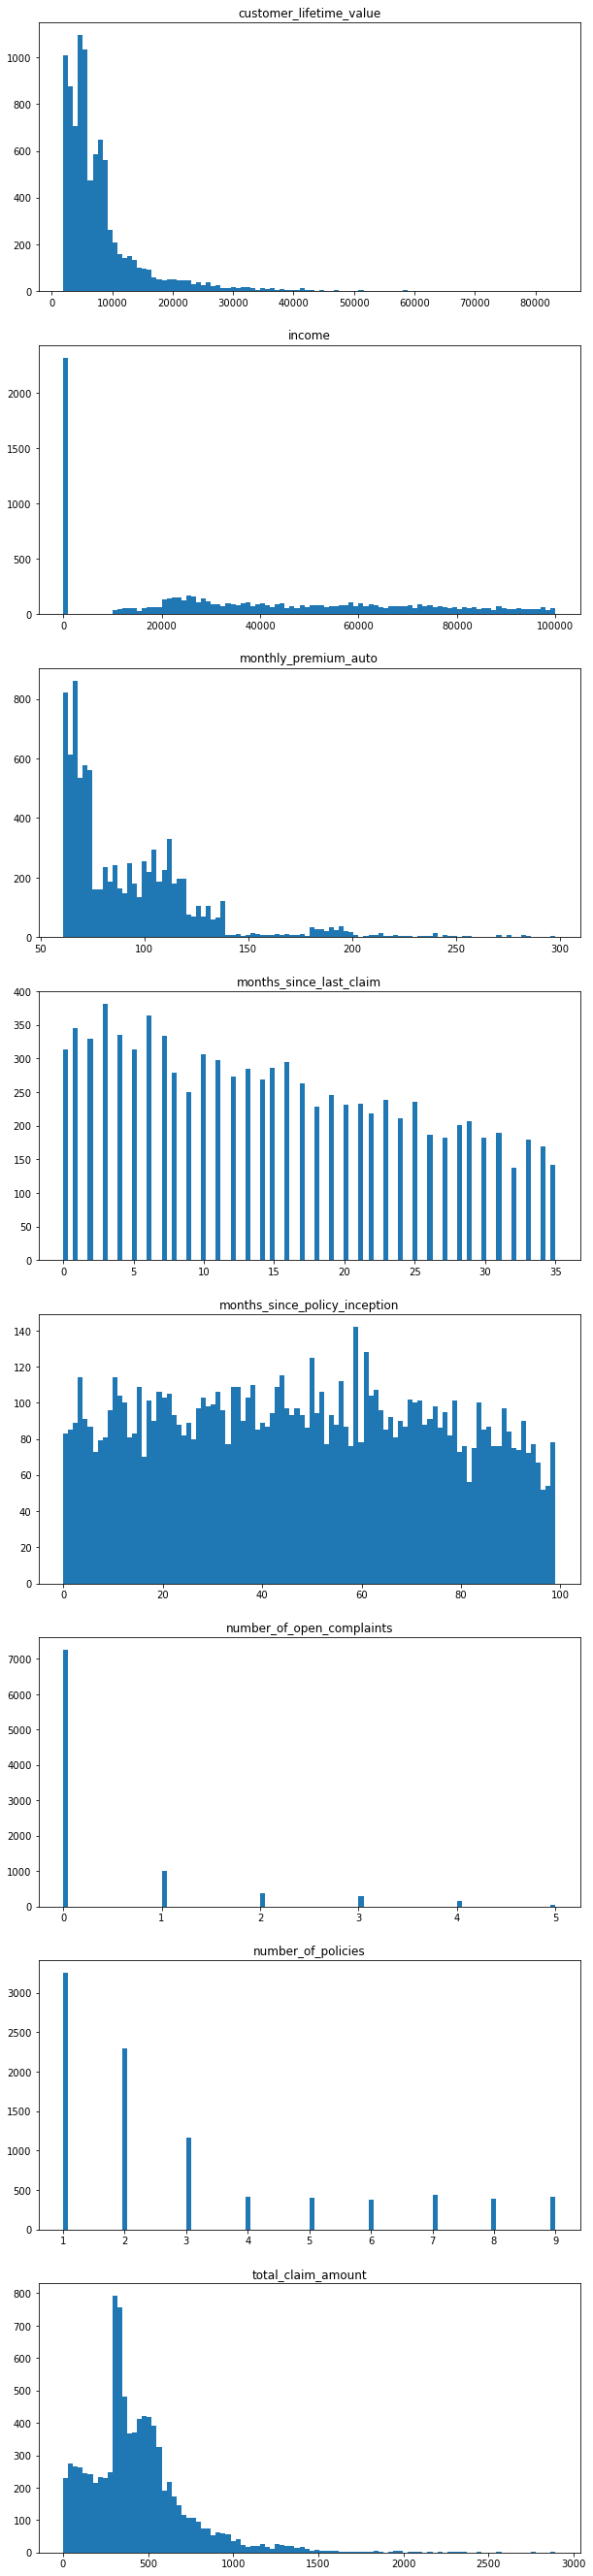

In [50]:
fig, axs = plt.subplots(data_num.shape[1], 1, figsize=(10,6*data_num.shape[1]))

for i in range(data_num.shape[1]):
    axs[i].hist(data_num[data_num.columns[i]], bins=100)
    axs[i].title.set_text(data_num.columns[i])
plt.show()    

In [6]:
# let's fix 'customer_lifetime_value'

In [7]:
# log transform function
def log_t(x):
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN # We are returning NaNs so that we can replace them with means later    

In [8]:
# cox box transform function
def cox_box_t(x):
    xt, lmbda = stats.boxcox(x)
    return xt

In [9]:
# 'h' stands for histogram and 's' for side by side, as the functions will be plotted next to each other
def plot_hs(vector):
    if len(vector)==2:
        names = ['original', 'transformed']
    elif len(vector)==3:
        names = ['original', 'log transform', 'cox-box transform']

    fig, axs = plt.subplots(1, len(vector), sharey=False, figsize=(14,5))
    for i in range(len(vector)):
        axs[i].hist(vector[i], bins=100)
        axs[i].title.set_text(names[i])
    plt.show()    

In [10]:
data['customer_lifetime_value_log'] = list(map(log_t, data['customer_lifetime_value']))
data['customer_lifetime_value_coxbox'] = list(cox_box_t(data['customer_lifetime_value']))

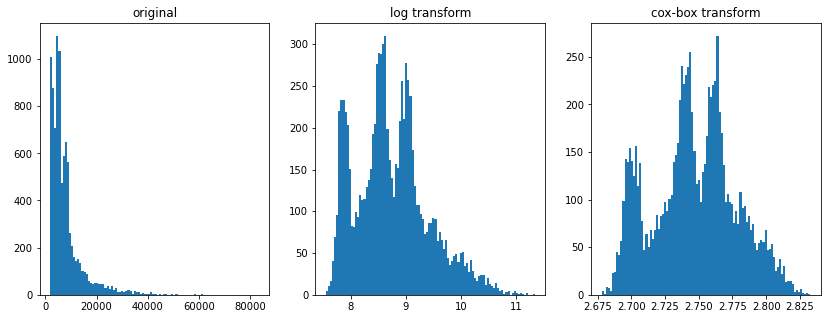

In [11]:
plot_hs([data['customer_lifetime_value'],data['customer_lifetime_value_log'], data['customer_lifetime_value_coxbox']])

In [12]:
# cox-box looks better so we drop both original and log transform versions
data = data.drop('customer_lifetime_value', axis=1)
data = data.drop('customer_lifetime_value_log', axis=1)

In [13]:
# now fix 'income'

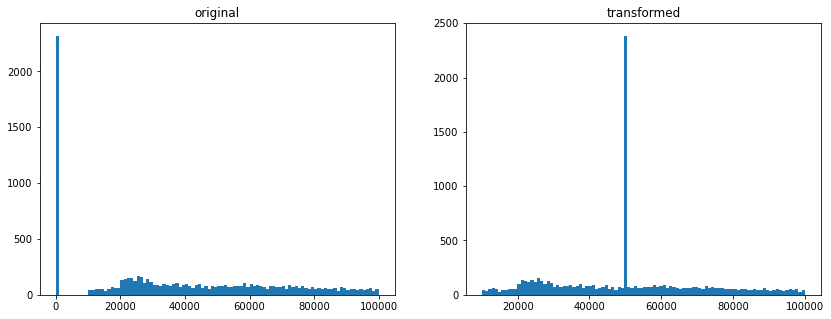

In [14]:
data['income_transformed'] = np.where(data['income']<=0,0,data['income'])
# now calculate mean of the new column , exluding zeros in the count 
mean = np.sum(data['income_transformed'])/len(data[data['income_transformed']>0])
data['income_transformed'] = data['income_transformed'].replace(0,mean)
plot_hs([data['income'], data['income_transformed']])

In [15]:
data = data.drop('income', axis=1) 

In [16]:
# fix 'monthly_premium_auto'

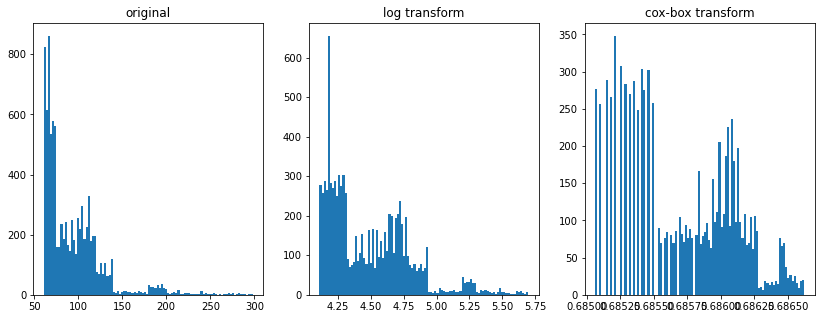

In [17]:
data['monthly_premium_auto_log'] = list(map(log_t, data['monthly_premium_auto']))
data['monthly_premium_auto_coxbox'] = list(cox_box_t(data['monthly_premium_auto']))
plot_hs([data['monthly_premium_auto'],data['monthly_premium_auto_log'], data['monthly_premium_auto_coxbox']])

In [18]:
# cox-box looks better so we drop both original and log transform versions
data = data.drop('monthly_premium_auto', axis=1)
data = data.drop('monthly_premium_auto_log', axis=1)

In [19]:
# now 'total_claim_amount'

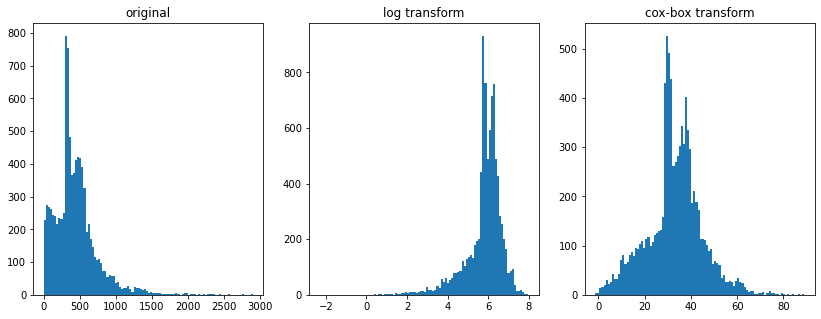

In [20]:
data['total_claim_amount_log'] = list(map(log_t, data['total_claim_amount']))
data['total_claim_amount_coxbox'] = list(cox_box_t(data['total_claim_amount']))
plot_hs([data['total_claim_amount'],data['total_claim_amount_log'], data['total_claim_amount_coxbox']])

In [21]:
# cox-box looks better so we drop both original and log transform versions
data = data.drop('total_claim_amount', axis=1)
data = data.drop('total_claim_amount_log', axis=1)

In [22]:
# x-y split

In [23]:
Y = data['total_claim_amount_coxbox']
data = data.drop(['total_claim_amount_coxbox'], axis=1)

In [24]:
# Standardizing

In [25]:
X_num = data.select_dtypes(include = np.number)

In [26]:
transformer = Normalizer().fit(X_num)
x_normalized = transformer.transform(X_num)
x_normalized = pd.DataFrame(x_normalized)

In [27]:
x_normalized.head()

,0,1,2,3,4,5,6
0,0.000569,0.000089,0.0,0.000018,0.000048,1.000000,0.000012
1,0.000258,0.000832,0.0,0.000159,0.000055,1.000000,0.000014
2,0.000369,0.000779,0.0,0.000041,0.000057,1.000000,0.000014
3,0.000357,0.001288,0.0,0.000139,0.000055,0.999999,0.000014
4,0.000274,0.001004,0.0,0.000023,0.000062,0.999999,0.000016


In [28]:
# One Hot/Label Encoding (categorical).

In [29]:
X_cat = data.select_dtypes(include = np.object)

In [30]:
X_cat.head()

,customer,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,BU79786,Washington,No,Basic,Bachelor,2/24/11,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,QZ44356,Arizona,No,Extended,Bachelor,1/31/11,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,AI49188,Nevada,No,Premium,Bachelor,2/19/11,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,WW63253,California,No,Basic,Bachelor,1/20/11,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,HB64268,Washington,No,Basic,Bachelor,2/3/11,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize


In [31]:
X_cat = X_cat.drop('customer', axis=1)

In [32]:
X_cat.head()

,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,Washington,No,Basic,Bachelor,2/24/11,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,No,Extended,Bachelor,1/31/11,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,No,Premium,Bachelor,2/19/11,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,California,No,Basic,Bachelor,1/20/11,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,Washington,No,Basic,Bachelor,2/3/11,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize


In [33]:
for s in X_cat.columns:
    print(s)
    print(X_cat[s].unique())

state
['Washington' 'Arizona' 'Nevada' 'California' 'Oregon']
response
['No' 'Yes']
coverage
['Basic' 'Extended' 'Premium']
education
['Bachelor' 'College' 'Master' 'High School or Below' 'Doctor']
effective_to_date
['2/24/11' '1/31/11' '2/19/11' '1/20/11' '2/3/11' '1/25/11' '1/18/11'
 '1/26/11' '2/17/11' '2/21/11' '1/6/11' '2/6/11' '1/10/11' '1/17/11'
 '1/5/11' '2/27/11' '1/14/11' '1/21/11' '2/5/11' '1/29/11' '2/28/11'
 '2/12/11' '2/2/11' '2/7/11' '1/22/11' '2/13/11' '1/15/11' '1/8/11'
 '1/11/11' '1/28/11' '2/8/11' '2/23/11' '1/2/11' '2/16/11' '1/27/11'
 '1/23/11' '1/9/11' '2/11/11' '2/4/11' '2/1/11' '2/15/11' '2/26/11'
 '1/16/11' '1/1/11' '2/10/11' '1/24/11' '2/25/11' '1/12/11' '2/9/11'
 '1/19/11' '1/4/11' '2/14/11' '2/20/11' '2/18/11' '1/3/11' '1/13/11'
 '1/30/11' '2/22/11' '1/7/11']
employmentstatus
['Employed' 'Unemployed' 'Medical Leave' 'Disabled' 'Retired']
gender
['F' 'M']
location_code
['Suburban' 'Rural' 'Urban']
marital_status
['Married' 'Single' 'Divorced']
policy_type
['C

In [34]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(X_cat)
encoded = encoder.transform(X_cat).toarray()
encoded

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.]])

In [35]:
X = np.concatenate((x_normalized, encoded), axis=1)
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,0.000569,0.000089,0.0,0.000018,0.000048,1.000000,0.000012,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.000258,0.000832,0.0,0.000159,0.000055,1.000000,0.000014,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000369,0.000779,0.0,0.000041,0.000057,1.000000,0.000014,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.000357,0.001288,0.0,0.000139,0.000055,0.999999,0.000014,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.000274,0.001004,0.0,0.000023,0.000062,0.999999,0.000016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
### Linear Regression

# - Train-test split.
# - Apply linear regression.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [38]:
from sklearn import linear_model

In [39]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
predictions  = lm.predict(X_test)
r2_score(y_test, predictions)

0.8224154265467165

In [40]:
X_train.shape

(6393, 108)

In [41]:
pd.DataFrame(y_train).shape

(6393, 1)

In [42]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
model

LinearRegression()

In [43]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,0.000071,0.001555,0.000018,0.000106,0.000048,0.999999,0.000012,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000141,0.000565,0.000000,0.000047,0.000129,1.000000,0.000032,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.000325,0.002450,0.000000,0.000266,0.000081,0.999997,0.000020,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000342,0.000285,0.000000,0.000057,0.000155,1.000000,0.000039,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000095,0.001138,0.000000,0.000152,0.000052,0.999999,0.000013,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,0.000377,0.000793,0.000000,0.000040,0.000055,1.000000,0.000014,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2737,0.000835,0.001136,0.000000,0.000033,0.000090,0.999999,0.000023,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2738,0.000163,0.000163,0.000036,0.000163,0.000050,1.000000,0.000012,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2739,0.000207,0.000703,0.000000,0.000041,0.000058,1.000000,0.000014,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [44]:
len(lm.predict(X_test))

2741

In [45]:
### Model Validation

# - Description:
#   - R2.
#   - MSE.
#   - RMSE.
#   - MAE.

In [46]:
r2 = r2_score(y_test, predictions)
r2

0.8224154265467165

In [47]:
mse = mean_squared_error(y_test, predictions)
print(mse)

24.760543098758546


In [48]:
rmse = math.sqrt(mse)
print(rmse)

4.975996694005991


In [49]:
n = len(X_test) 
p = X_test.shape[1]
adj_r2 = 1-((1-r2)*(n-1)/(n-p-1))
adj_r2

0.8151285215569921